## Exploratory Data Analysis - Team 8

### 1. EDA General

#### 1.1 Lectura y Limpieza de Datos

#### 1.2 Análisis Univariado

* Evolución de altas 
* Evolución de inicios de sesión
* Evolución de consumos (in y out)
* Variables características (números globales : edad, sexo, provincia, antiguedad)

#### 1.3 Análisis Multivariado

* Matriz correlaciones (Pearson). 
* Relaciones entre variables pre reglas asociación

### 2. EDA Reglas Apriori

* Productos totales
* Items más frecuentes
* Reglas más frecuentes
* Reglas de negocio



In [ ]:
%pip install mlxtend
%pip install awswrangler
%pip install pingouin
%pip install geopy
%pip install folium

Importamos paquetes y librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import boto3
from datetime import datetime, timedelta
import awswrangler as wr
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
sns.set(style="whitegrid")
paleta_uala = ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD']
import pingouin as pg 
import scipy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example")
import folium 

# 1. EDA General

## 1.1 Lectura y Limpieza de Datos

Leemos el dataset alojado en un bucket de S3 de AWS en formato Parquet

In [2]:
df = wr.s3.read_parquet(f's3://test-uala-arg-datalake-aiml-recommendations/data/stage/all_data_v2/')
df.rename(columns={"nu_sin_categoria_aprob":"nu_compras_otras_categorias_aprob"}, inplace=True)

In [3]:
df.shape

(8018032, 111)

Chequeamos valores nulos.

In [4]:
df.isnull().sum()

year_month                                      0
os_name                                         0
cobros                                    3804298
cuotificaciones                            986498
inversiones                                     0
pago_servicios                                  0
prestamos                                       0
promociones                               3804298
recargas                                        0
transferencia_c2c                          418894
transferencia_cvu                          418894
account_id                                      0
external_id                                     0
vl_cashin_efectivo_sum                          0
vl_cashin_inversiones_sum                       0
vl_cashin_transferencia_sum                     0
vl_cashin_prestamos_sum                         0
vl_cashin_c2c_sum                               0
vl_cashin_adquirencia_sum                       0
vl_cashin_ajustes_sum                           0


In [5]:
df[['cobros','cuotificaciones','promociones','transferencia_c2c','transferencia_cvu']] = df[['cobros','cuotificaciones','promociones','transferencia_c2c','transferencia_cvu']].fillna(0)

In [6]:
df = df.dropna()

Modificamos el tipo dato para la variable "dt" y renombramos.

In [7]:
df['dt'] = pd.to_datetime(df['dt'])

In [8]:
df = df.rename({'dt':'periodo'}, axis=1)

Generamos la variable Antigüedad:

In [9]:
# Variable máximo periodo disponible
max_periodo = df.periodo.max()
max_periodo = pd.to_datetime(max_periodo)

In [10]:
df.fecha_alta = pd.to_datetime(df.fecha_alta)
df.fecha_alta = np.where(df.fecha_alta > max_periodo , max_periodo, df.fecha_alta.dt.date)

In [11]:
df['antiguedad']= max_periodo - df.fecha_alta

In [12]:
df['antiguedad'] = df['antiguedad'].dt.days

## 1.2 Univariate Analysis

### App Usage Growth

In [13]:
temp = (df
 .groupby("periodo")
 .account_id
 .agg('count')
)

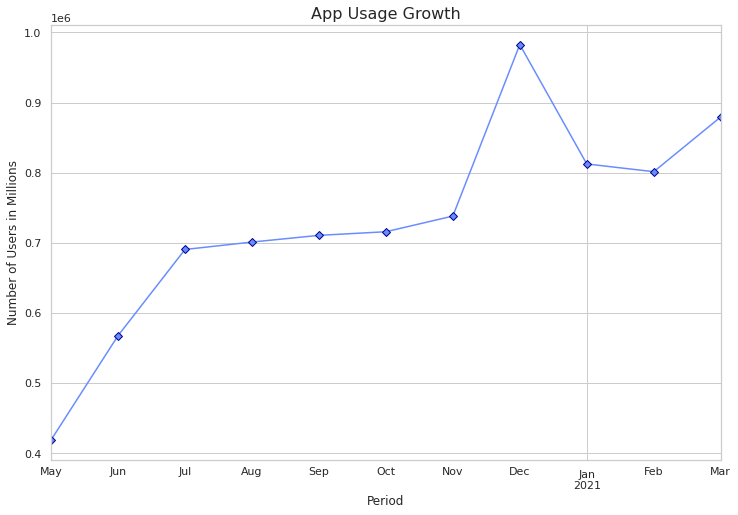

In [14]:
ax = temp.plot(figsize=(12,8), color='#698cff',marker='D', markeredgecolor='darkblue')
ax.set_xlabel("Period")
ax.set_ylabel("Number of Users in Millions")
_ = ax.set_title("App Usage Growth", fontsize=16)

### Evolución de Clientes Nuevos

In [15]:
temp = df.copy()
temp['periodo_alta'] = pd.to_datetime(df['fecha_alta'], format='%Y/%m').dt.strftime('%Y-%m')

temp = (temp
 .groupby("periodo_alta")
 .account_id
 .agg('count')
)


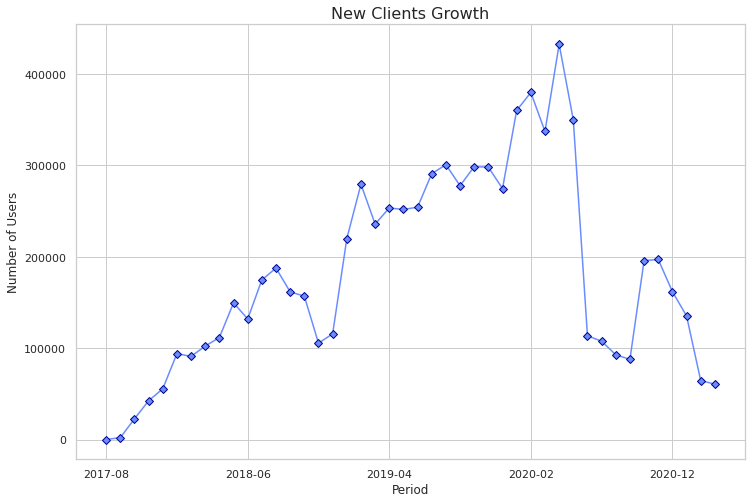

In [16]:
ax = temp.plot(figsize=(12,8), color='#698cff',marker='D', markeredgecolor='darkblue')
ax.set_xlabel("Period")
ax.set_ylabel("Number of Users")
_ = ax.set_title("New Clients Growth", fontsize=16)

En los graficos analizados arriba, se observa que si bien la cantidad de altas de usuarios disminuyó durante la pandemia, se mantiene creciente la tendencia del uso de la app.

## Evolución de Montos Medios Transaccionados

### Cashout

In [17]:
temp = (df
 .groupby("periodo", as_index = False)['vl_compras_aprob',
                        'vl_withdraw_atm_aprob',
                        'vl_investments_deposit_aprob',
                        'vl_telerecargas_carga_aprob',
                        'vl_user_to_user_aprob', 
                        'vl_cash_out_cvu_aprob'
                       ]
 .agg('mean')
).rename(columns={"periodo":"period"})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [18]:
temp_pivot = temp.melt(var_name = "cashout",
                     value_name = "Media_usd",
                     id_vars = ["period"],
                     value_vars = ['vl_compras_aprob',
                        'vl_withdraw_atm_aprob',
                        'vl_investments_deposit_aprob',
                        'vl_telerecargas_carga_aprob',
                        'vl_user_to_user_aprob', 
                        'vl_cash_out_cvu_aprob']) 

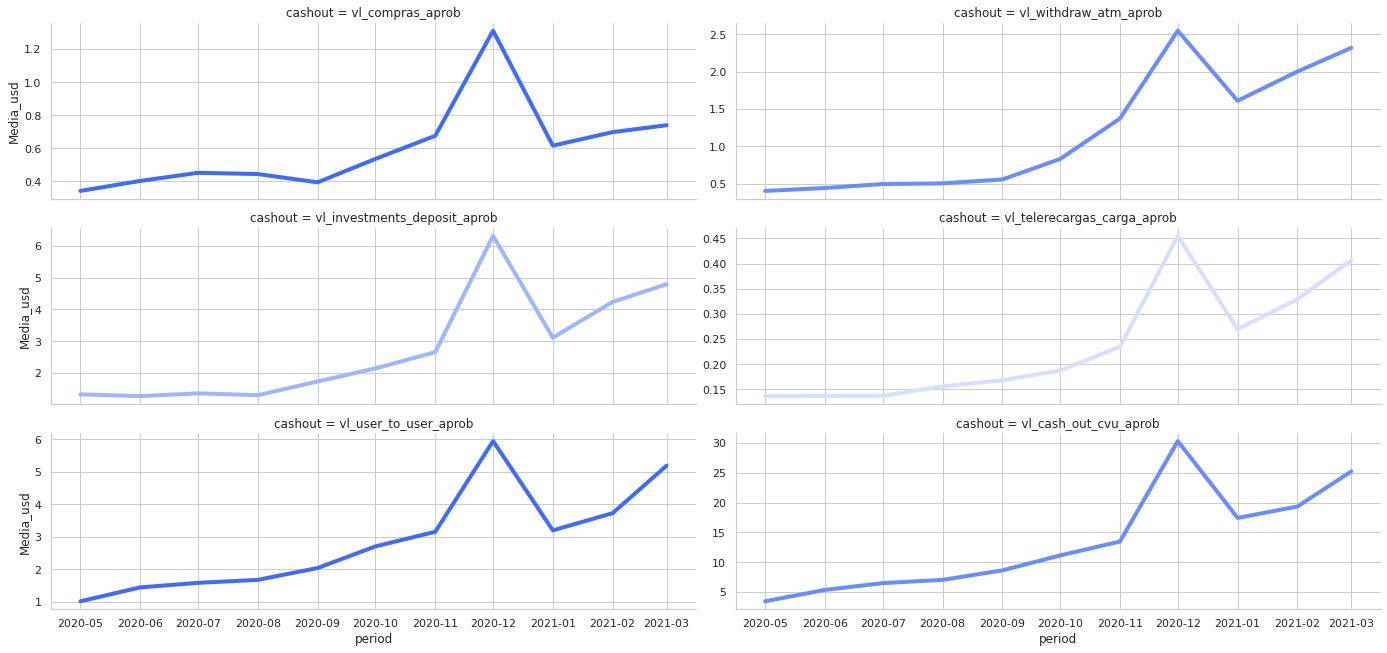

In [19]:
g = sns.relplot(
    data = temp_pivot,
    x="period", y="Media_usd", col="cashout", hue="cashout",
    kind="line", palette= ['#3E6BFD','#698cff','#9eb5ff','#d5dfff','#3E6BFD','#698cff'], linewidth=4, zorder=5,
    col_wrap=2, height=3, aspect=3.2, legend=False, facet_kws=dict(sharey=False)
)


Se observa en el grafico de promedios de montos cashout en dolares que hay una tendencia positiva con pico en diciembre, aunque presenta niveles diferentes segun el producto usado.

### Cashin

In [20]:
temp = (df
 .groupby("periodo", as_index = False)['vl_cashin_efectivo_sum',
                                       'vl_cashin_transferencia_sum']
 .agg('mean')
).rename(columns={"periodo":"period"})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


In [21]:
temp_pivot = temp.melt(var_name = "cashin",
                     value_name = "Media_usd",
                     id_vars = ["period"],
                     value_vars = ['vl_cashin_efectivo_sum',
                                  'vl_cashin_transferencia_sum'])

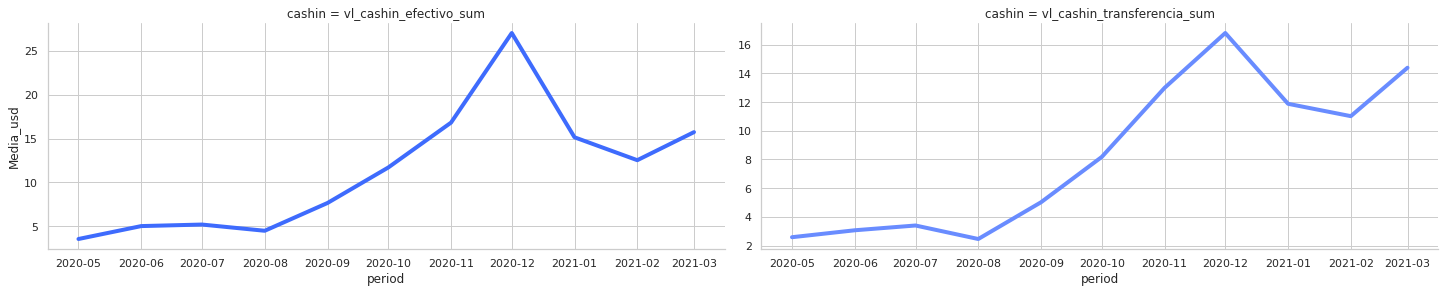

In [22]:
g = sns.relplot(
    data = temp_pivot,
    x="period", y="Media_usd", col="cashin", hue="cashin",
    kind="line", palette=['#3E6BFD','#698cff'], linewidth=4, zorder=5,
    col_wrap=2, height=4, aspect=2.5, legend=False, facet_kws=dict(sharey=False)
)

Se observa en el grafico de promedios de montos cashin en dolares que hay una tendencia positiva con pico en diciembre. Siendo en el caso de cashin en efectivo los ascensos y caidas mas abruptos respecto de las transferencias.

## Evolución de Inicios de Sesión e Incidentes registrados

In [23]:
temp = (df
 .groupby("periodo", as_index = False)['nu_incidente',
                                       'nu_inicio',
                                       'nu_bloqueo']
 .agg('mean')
 .fillna(0)
).rename(columns={"periodo":"period"})

temp_pivot = temp.melt(var_name = "evento",
                       value_name = "cantidad_media",
                       id_vars = ["period"],
                       value_vars = ['nu_incidente',
                                     'nu_inicio',
                                    'nu_bloqueo'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


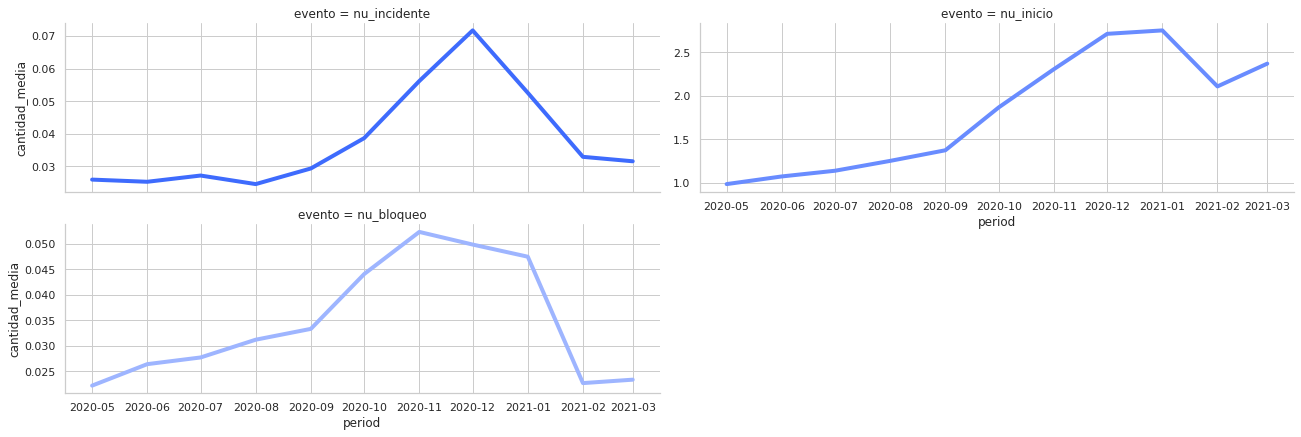

In [24]:
g = sns.relplot(
    data = temp_pivot,
    x="period", y="cantidad_media", col="evento", hue="evento",
    kind="line", palette= ['#3E6BFD','#698cff','#9eb5ff'], linewidth=4, zorder=5,
    col_wrap=2, height=3, aspect=3.0, legend=False, facet_kws=dict(sharey=False)
)

## Características Demográficas de los clientes

**Antigüedad como cliente**

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


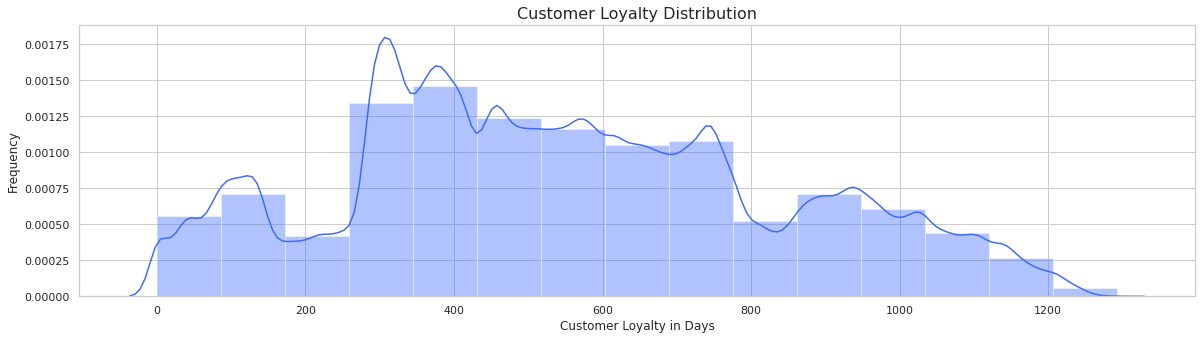

In [25]:
plt.figure(figsize=(20,5))

sns.distplot(df.antiguedad, kde=True, hist=True, bins=15, color='#3E6BFD')
plt.xlabel('Customer Loyalty in Days')
plt.ylabel('Frequency')
plt.title('Customer Loyalty Distribution', fontsize=16)
plt.show()

De la distribución de la antigüedad podemos confirmar que la cantidad de nuevos usuarios se fue reduciendo tocando minimo en el mes de Mayo del 2020 coincidiendo con el inicio de la pandemia en Argentina.

**Edad de los clientes**

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


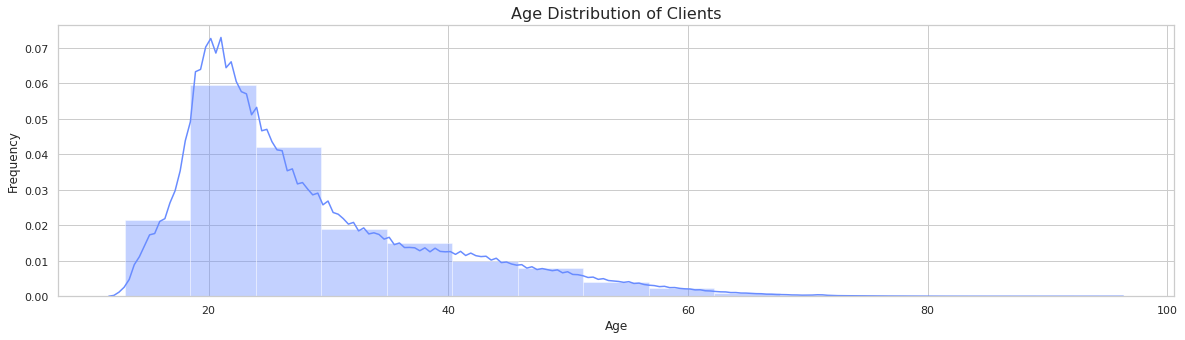

In [26]:
df['fecha_nacimiento'] = pd.to_datetime(df['fecha_nacimiento'], format='%Y/%m/%d')
df['edad']=[math.trunc((datetime.now()-i).days/365)  for i in df['fecha_nacimiento']]
plt.figure(figsize=(20,5))

sns.distplot(df.edad, kde=True, hist=True, bins=15, color='#698cff')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Clients', fontsize=16)

plt.show()

El grafico de distribución de edades presenta una asimetría de derecha, concentrando la base de usuarios en el rango etario de a 18 años a 30 años.

**Zonas donde residen los clientes**

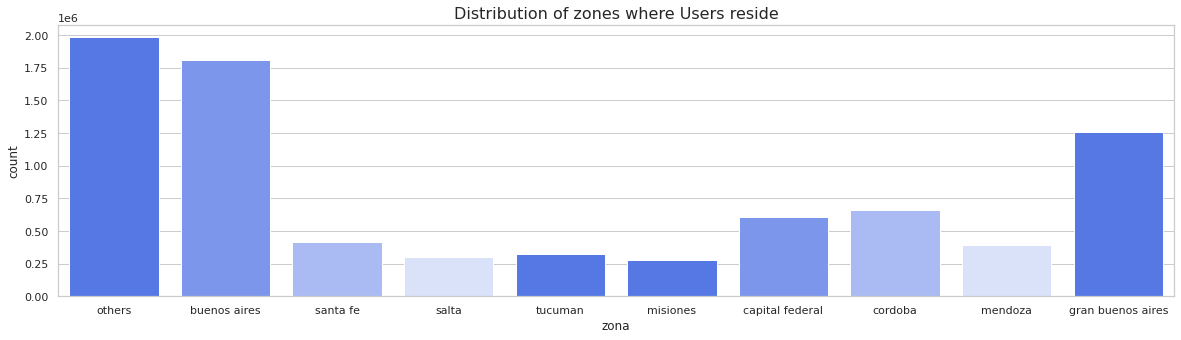

In [27]:
df['zona']=df.provincia.str.lower()
df.loc[-df.provincia.isin(['santa fe','cordoba','buenos aires','capital federal',
                                                            'gran buenos aires','mendoza','tucuman','salta',
                                                           'misiones']),\
                         'zona']='others'
plt.figure(figsize=(20,5))
sns.countplot(x=df.zona, palette=paleta_uala)
plt.title('Distribution of zones where Users reside', fontsize=16)

plt.show()

El grafico presenta las provincias mas pobladas de Argentina vs el resto. Dentro del mismo de se puede observar que la distribucion de usuarios de Ualá se concentra en la provincia de Buenos Aires, y la categoría 'Others' presenta una alta densidad ya que resume el numero de usuarios del resto de las provincias del país.

#### Unique Clients 's Location Map

In [ ]:
provincias=pd.DataFrame(df.groupby('provincia')['account_id'].nunique()).reset_index(False)
provincias['provincia']=provincias['provincia']+', Argentina'

In [ ]:
#Para mejorar la visibilad de puntos muy cercados muevo las coordenadas
provincias['provincia_coord_names']=np.where(provincias['provincia'].str.strip()=='buenos aires, Argentina','tandil,buenos aires',provincias['provincia'])
provincias['provincia_coord_names']=np.where(provincias['provincia_coord_names'].str.strip()=='gran buenos aires, Argentina','la matanza,buenos aires',provincias['provincia_coord_names'])

In [ ]:
l['COORDS'] = []

for k in provincias.provincia_coord_names.unique():
    loc = geolocator.geocode(k).raw
    l['COORDS'].append((loc['lat'], loc['lon']))
provincias['COOR']=l['COORDS']

In [ ]:
mapita = folium.Map(location=[-38,-64], zoom_start=3.5)

provincias['label']=provincias['provincia']+', Unique Users:'+provincias['account_id'].astype(str)

for i,r in provincias.iterrows():
      folium.Circle(
      location=r['COOR'],
      popup=r['label'],
      radius=r['account_id']/2,
      color='#69b3a2',
      fill=True,
      fill_color='#69b3a2'
   ).add_to(mapita)
mapita


## Empresa Telefónica y Sistema Operativo de los usuarios

**Empresa Telefónica**

In [28]:
temp = df.copy()

condlist=[
    temp.fl_carrier_claro == 1,
    temp.fl_carrier_movistar == 1,
    temp.fl_carrier_personal == 1,
    temp.fl_carrier_tuenti ==1
    
]

choicelist=['Claro','Movistar','Personal','Tuenti']
temp['cd_empresa_tel']=np.select(condlist,choicelist)
temp['cd_empresa_tel']=(np.where(temp['cd_empresa_tel']=='0','otros',temp['cd_empresa_tel']))

In [29]:
b = temp.groupby(['periodo','cd_empresa_tel']).account_id.count().reset_index(name='cantidad_clientes')
b = b[b.cd_empresa_tel != 'otros']
b['periodo']= b['periodo'].dt.date

In [30]:
b.rename(columns={"cd_empresa_tel":"phone_company"},inplace=True)
b_pivot = pd.pivot_table(
    b, 
    values="cantidad_clientes",
    index="periodo",
    columns="phone_company", 
    aggfunc='sum'
)

Text(0, 0.5, 'Number of Clients')

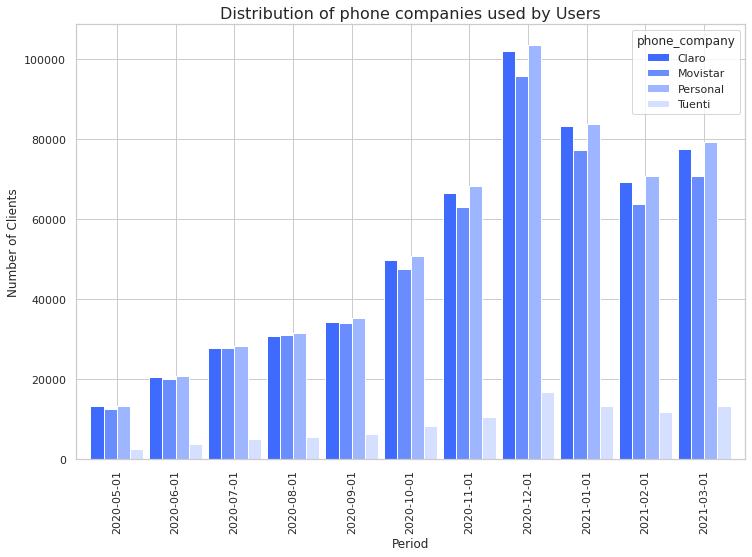

In [31]:
ax = b_pivot.plot(kind="bar", color= paleta_uala, width=0.9)
fig = ax.get_figure()
fig.set_size_inches(12, 8)

plt.title('Distribution of phone companies used by Users', fontsize=16)
ax.set_xlabel("Period")
ax.set_ylabel("Number of Clients")

De los usuarios que presentan que compañía telefónica utilizar, se observa una concentración distribuida en tres compañías: Personal, Claro y Movistar.

**Sistema Operativo**

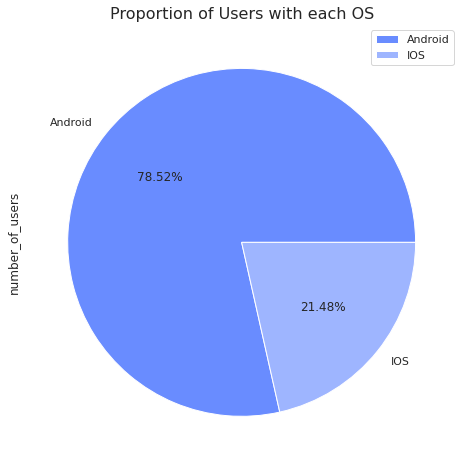

In [32]:
temp["Android_OS"] = np.where(temp.fl_os_android==0,'Android','IOS')
temp_pie = temp.groupby(["Android_OS"])["account_id"].count().reset_index(name="number_of_users")

ax = temp_pie.plot.pie(y="number_of_users", labels=temp_pie.Android_OS, autopct="%1.2f%%", figsize=(10, 8), colors=['#698cff','#9eb5ff'])
_ = ax.set_title("Proportion of Users with each OS", fontsize=16)

El grafico muestra que la mayoría de los usuarios tiene sistema operativo Android.

## 1.3 Análisis Multivariado

### Matriz de Correlación Total

Se realizó una matriz de correlación de Pearson para evaluar con mas detalle el grado de correlación lineal de las variables y visualizar las mas interesantes para nuestro análisis.

In [33]:
# Seleccionamos las variables que no queremos tener dentro de la matriz de correlación
a = df.columns.isin(['account_id','year_month','os_name','external_id','periodo','fecha_alta','provincia','sexo','fecha_nacimiento','zona'])
a_comple = df.columns[~a]

# Creamos un df nuevo sin las variables que elegimos
df_ = df.loc[:,a_comple]

Para este analisis se descartaron las correlaciones lineales mas fuertes, es decir, mayores al 90% y menores al 0.5%, para simplificar el análisis bivariados entendiendo la cantidad de variables que presenta el dataset.

In [34]:
# Matriz de correlación (corr en varlores absolutos)
temp = df_.copy()
corr_matrix = temp.corr().abs()

# Seleccionamos triángulo superior
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Vamos a eliminar variables con correlaciones mayores al percentil XXXXX y menores al percentil XXXXXX
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop2 = [column for column in upper.columns if any(upper[column] < 0.005)]

# Eliminamos esas listas
temp.drop(to_drop+to_drop2, axis=1, inplace=True)

temp.shape

(8018021, 13)

In [35]:
# Matríz de Correlación
matriz = temp.corr()

**Heatmaps**

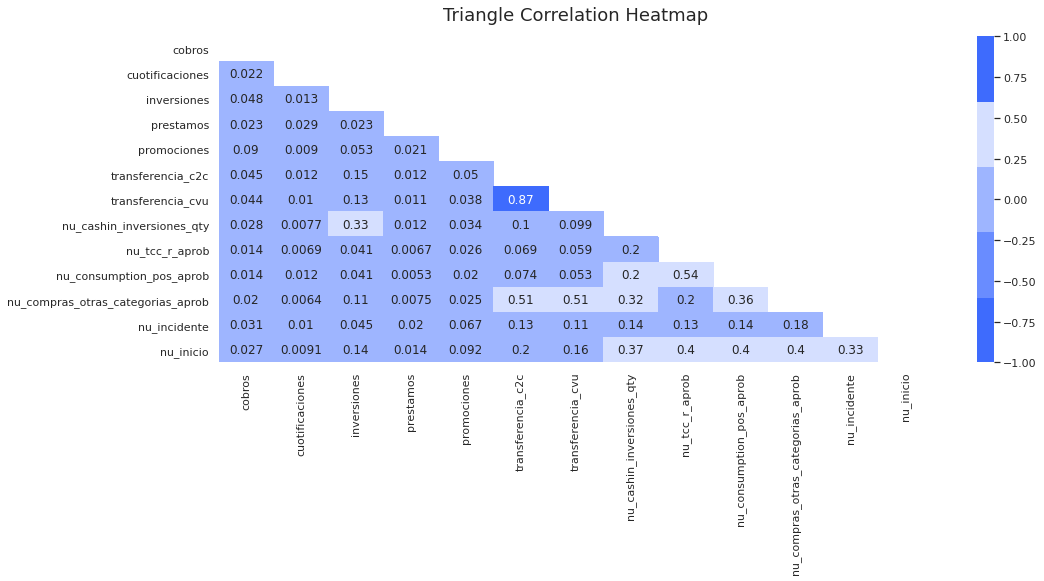

In [36]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(matriz, dtype=np.bool))
heatmap = sns.heatmap(matriz, mask=mask, vmin=-1, vmax=1, annot=True, cmap=paleta_uala)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

A partir del heatmap anterior se destancan las siguientes correlaciones:
* inversiones -> 	transferencia_cvu
* transferencia_c2c -> nu_compras_otras_categorias_aprob	
* nu_cashin_inversiones_qty -> nu_consumption_pos_aprob
* nu_tcc_r_aprob -> nu_incidente
* nu_inicio -> transferencia_cvu, nu_cashin_inversiones_qty, nu_tcc_r_aprob, nu_consumption_pos_aprob, nu_compras_otras_categorias_aprob, nu_incidente

## Relaciones Bivariadas

In [ ]:
g=sns.pairplot(
    temp,
    x_vars=["inversiones", "transferencia_cvu", "transferencia_c2c", "nu_compras_otras_categorias_aprob", 
"nu_cashin_inversiones_qty", "nu_consumption_pos_aprob", "nu_tcc_r_aprob", "nu_incidente", "nu_inicio"],
    y_vars=["inversiones", "transferencia_cvu", "transferencia_c2c", "nu_compras_otras_categorias_aprob", 
"nu_cashin_inversiones_qty", "nu_consumption_pos_aprob", "nu_tcc_r_aprob", "nu_incidente", "nu_inicio"]
)
g.fig.set_figheight(20)
g.fig.set_figwidth(25)
plt.show()

Se confirma graficamente la relacion lineal de las siguientes variables:

* transferencia_cvu con nu_compras_otras_categ
* nu_inicio con cahin_inv
* nu_inicio con tcc_r_aprob
* transferencia_cvu con transferencia_c2c

# 2. EDA Rules [Apriori](http://www.vldb.org/conf/1994/P487.PDF)

Con la intención de entender el cross-selling dentro de los productos de Ualá, se procede a correr un algoritmo de reglas de asociación que permita medir la frequencia de uso de la cesta de productos que oferece la empresa.

Se eliminan las variables que no se desea tener dentro de la matriz. Para dar prioridad a la transaccionalidad mas reciente de los usuarios se procede a analizar el ultimo mes disponible en el dataset:

In [37]:
df_=df[df['periodo']=='2021-03'].copy()
a = df_.columns.isin(['year_month','os_name','external_id','periodo','fecha_alta','provincia','sexo','fecha_nacimiento','zona','edad'])
a_comple = df_.columns[~a]

df_ = df_.loc[:,a_comple]

In [38]:
data_pivot = pd.melt(df_, 
                     id_vars='account_id', 
                     var_name='producto', 
                     value_name='value')

In [39]:
data_pivot = data_pivot[data_pivot.value > 0]

In [40]:
data_matriz = (data_pivot
               .groupby(['account_id', 'producto'])['value']
               .sum().unstack().reset_index().fillna(0)
               .set_index('account_id'))

In [41]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

data_matriz = data_matriz.applymap(encode_units)

A continuación se selecionan las transacciones relacionadas con los productos de interés para recomendar por parte del stakeholder:

In [81]:
data_matriz_test = data_matriz[[
 #'nu_cashin_prestamos_qty',
 #'nu_cashin_adquirencia_qty',
 'nu_investments_deposit_aprob',
 'nu_telerecargas_carga_aprob',
 'nu_compras_otras_categorias_aprob',
 'nu_compras_aprob',
 'nu_entretenimiento_aprob',
 'nu_servicios_débitos_automaticos_aprob',
 'nu_supermercados_alimentos_aprob']]

In [43]:
#data_matriz_test= data_matriz

In [82]:
data_matriz_test.isnull().sum()

producto
nu_investments_deposit_aprob              0
nu_telerecargas_carga_aprob               0
nu_compras_otras_categorias_aprob         0
nu_compras_aprob                          0
nu_entretenimiento_aprob                  0
nu_servicios_débitos_automaticos_aprob    0
nu_supermercados_alimentos_aprob          0
dtype: int64

In [83]:
data_matriz_test.shape

(873391, 7)

In [96]:
itemsets = apriori(data_matriz_test, min_support=0.03, use_colnames=True)

In [97]:
rules = association_rules(itemsets, metric="lift", min_threshold=2)

In [98]:
pd.set_option('display.max_colwidth', None)
itemsets

,support,itemsets
0,0.060448,(nu_investments_deposit_aprob)
1,0.070819,(nu_telerecargas_carga_aprob)
2,0.200978,(nu_compras_otras_categorias_aprob)
3,0.030897,(nu_compras_aprob)
4,0.039618,(nu_entretenimiento_aprob)
5,0.094297,(nu_servicios_débitos_automaticos_aprob)
6,0.033479,(nu_supermercados_alimentos_aprob)
7,0.060448,"(nu_compras_otras_categorias_aprob, nu_investments_deposit_aprob)"
8,0.070819,"(nu_compras_otras_categorias_aprob, nu_telerecargas_carga_aprob)"
9,0.034592,"(nu_servicios_débitos_automaticos_aprob, nu_telerecargas_carga_aprob)"


In [99]:
rules.sort_values(by='support', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(nu_compras_otras_categorias_aprob),(nu_servicios_débitos_automaticos_aprob),0.200978,0.094297,0.080045,0.398281,4.223691,0.061094,1.505192
8,(nu_servicios_débitos_automaticos_aprob),(nu_compras_otras_categorias_aprob),0.094297,0.200978,0.080045,0.848867,4.223691,0.061094,5.286888
2,(nu_compras_otras_categorias_aprob),(nu_telerecargas_carga_aprob),0.200978,0.070819,0.070819,0.352374,4.975680,0.056586,1.434750
3,(nu_telerecargas_carga_aprob),(nu_compras_otras_categorias_aprob),0.070819,0.200978,0.070819,1.000000,4.975680,0.056586,inf
1,(nu_investments_deposit_aprob),(nu_compras_otras_categorias_aprob),0.060448,0.200978,0.060448,1.000000,4.975680,0.048300,inf
0,(nu_compras_otras_categorias_aprob),(nu_investments_deposit_aprob),0.200978,0.060448,0.060448,0.300771,4.975680,0.048300,1.343697
5,(nu_telerecargas_carga_aprob),(nu_servicios_débitos_automaticos_aprob),0.070819,0.094297,0.034592,0.488448,5.179903,0.027914,1.770502
4,(nu_servicios_débitos_automaticos_aprob),(nu_telerecargas_carga_aprob),0.094297,0.070819,0.034592,0.366837,5.179903,0.027914,1.467523
12,"(nu_servicios_débitos_automaticos_aprob, nu_compras_otras_categorias_aprob)",(nu_telerecargas_carga_aprob),0.080045,0.070819,0.034592,0.432149,6.102136,0.028923,1.636312
13,"(nu_servicios_débitos_automaticos_aprob, nu_telerecargas_carga_aprob)",(nu_compras_otras_categorias_aprob),0.034592,0.200978,0.034592,1.000000,4.975680,0.027639,inf


In [93]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(nu_investments_deposit_aprob),(nu_telerecargas_carga_aprob),0.060448,0.070819,0.017849,0.295274,4.169399,0.013568,1.318499
1,(nu_telerecargas_carga_aprob),(nu_investments_deposit_aprob),0.070819,0.060448,0.017849,0.252033,4.169399,0.013568,1.256141
2,(nu_compras_otras_categorias_aprob),(nu_investments_deposit_aprob),0.200978,0.060448,0.060448,0.300771,4.975680,0.048300,1.343697
3,(nu_investments_deposit_aprob),(nu_compras_otras_categorias_aprob),0.060448,0.200978,0.060448,1.000000,4.975680,0.048300,inf
4,(nu_servicios_débitos_automaticos_aprob),(nu_investments_deposit_aprob),0.094297,0.060448,0.025867,0.274315,4.538003,0.020167,1.294709
5,(nu_investments_deposit_aprob),(nu_servicios_débitos_automaticos_aprob),0.060448,0.094297,0.025867,0.427919,4.538003,0.020167,1.583174
6,(nu_compras_otras_categorias_aprob),(nu_telerecargas_carga_aprob),0.200978,0.070819,0.070819,0.352374,4.975680,0.056586,1.434750
7,(nu_telerecargas_carga_aprob),(nu_compras_otras_categorias_aprob),0.070819,0.200978,0.070819,1.000000,4.975680,0.056586,inf
8,(nu_compras_aprob),(nu_telerecargas_carga_aprob),0.030897,0.070819,0.011404,0.369094,5.211765,0.009216,1.472772
9,(nu_telerecargas_carga_aprob),(nu_compras_aprob),0.070819,0.030897,0.011404,0.161027,5.211765,0.009216,1.155106


Se observa que el producto de inversiones es el mas presente en el cross-selling de la cesta de productos, tanto el rol de antecedente como de consecuente.
Esto puede actuar de base para evaluar a futuro los modelos a aplicar y la población de usuarios a analizar.